In [1]:
import json

In [3]:
filename='samples.txt'

In [4]:

answer_count = 0
all_keys = set()

def collect_keys(obj, prefix=""):
    for key, value in obj.items():
        full_key = f"{prefix}.{key}" if prefix else key
        all_keys.add(full_key)
        if isinstance(value, dict):
            collect_keys(value, prefix=full_key)

with open(filename, 'r') as f:
    buffer = ""
    brace_count = 0

    for char in f.read():
        if char == '{':
            brace_count += 1
        if char == '}':
            brace_count -= 1
        buffer += char
        if brace_count == 0 and buffer.strip():
            try:
                record = json.loads(buffer)
                if "answer" in record:
                    answer_count += 1
                    collect_keys(record["answer"])
            except Exception as e:
                print(f"Error parsing record: {e}")
            buffer = ""

# Output
print(f"Total 'answer' blocks found: {answer_count}")
print("All unique keys inside each 'answer':")
for key in sorted(all_keys):
    print(f" - {key}")




Total 'answer' blocks found: 36
All unique keys inside each 'answer':
 - activeFrameCPULoad
 - activity
 - datenow
 - dopplerIdx
 - doppz
 - interChirpProcessingMargin
 - interFrameCPULoad
 - interFrameProcessingMargin
 - interFrameProcessingTime
 - noiseDB
 - numDetectedObj
 - rangeIdx
 - rp_y
 - snrDB
 - timenow
 - transmitOutputTime
 - x_coord
 - y_coord
 - z_coord


In [7]:
import matplotlib.pyplot as plt
import os
output_folder = "rp_y_graphs"
os.makedirs(output_folder, exist_ok=True)

def extract_json_objects(raw):
    buffer = ""
    brace_count = 0
    objects = []

    for char in raw:
        if char == '{':
            brace_count += 1
        if char == '}':
            brace_count -= 1
        buffer += char
        if brace_count == 0 and buffer.strip():
            try:
                obj = json.loads(buffer)
                objects.append(obj)
            except Exception as e:
                print(f"Error parsing JSON object: {e}")
            buffer = ""
    return objects

with open(filename, "r") as f:
    raw_content = f.read()

json_objects = extract_json_objects(raw_content)

plot_count = 0
rp_y_all = []
for i, obj in enumerate(json_objects):
    answer = obj.get("answer", {})
    rp_y = answer.get("rp_y", None)
    if rp_y and isinstance(rp_y, list) and len(rp_y) > 0:
        plt.figure(figsize=(6, 4))
        rp_y_all.append(rp_y)
        plt.plot(range(len(rp_y)), rp_y, marker='o')
        plt.title(f'rp_y Plot - Frame {i+1}')
        plt.xlabel('Detection Index')
        plt.ylabel('rp_y (m)')
        plt.grid(True)
        filepath = os.path.join(output_folder, f'rp_y_plot_{i+1}.png')
        plt.savefig(filepath)
        plt.close()
        plot_count += 1

print(f"Total graphs plotted and saved: {plot_count}")
print(f"Saved in folder: {output_folder}")


Total graphs plotted and saved: 36
Saved in folder: rp_y_graphs


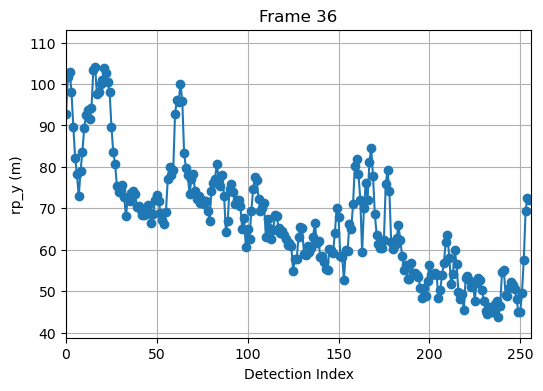

In [9]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(6, 4))
line, = ax.plot([], [], marker='o')
ax.set_xlabel("Detection Index")
ax.set_ylabel("rp_y (m)")
ax.grid(True)

def init():
    ax.set_xlim(0, max(len(arr) for arr in rp_y_all))
    ax.set_ylim(
        min(min(arr) for arr in rp_y_all),
        max(max(arr) for arr in rp_y_all)
    )
    return line,

def update(frame):
    y = rp_y_all[frame]
    x = list(range(len(y)))
    line.set_data(x, y)
    ax.set_title(f"Frame {frame+1}")
    return line,

ani = animation.FuncAnimation(
    fig, update,
    frames=len(rp_y_all),
    init_func=init,
    blit=True,
    interval=500
)

ani.save("rp_y_animation.gif", writer='pillow') 

plt.show()


In [11]:
import numpy as np
output_folder = "doppz_heatmaps"
os.makedirs(output_folder, exist_ok=True)


frame_count = 0
doppz_all = []
for obj in json_objects:
    answer = obj.get("answer", {})
    doppz = answer.get("doppz", [])

    if isinstance(doppz, list) and all(isinstance(row, list) for row in doppz):
        matrix = np.array(doppz)
        doppz_all.append(matrix)
        plt.figure(figsize=(8, 5))
        plt.imshow(matrix, aspect='auto', cmap='jet', origin='lower')
        plt.colorbar(label='Signal Magnitude')
        plt.xlabel("Range Bins")
        plt.ylabel("Doppler Bins (Velocity)")
        plt.title(f"Range-Doppler Heatmap — Frame {frame_count + 1}")
        
        filepath = os.path.join(output_folder, f"range_doppler_heatmap_{frame_count + 1}.png")
        plt.savefig(filepath)
        plt.close()
        frame_count += 1

print(f"Saved {frame_count} heatmaps in folder: {output_folder}")


Saved 36 heatmaps in folder: doppz_heatmaps


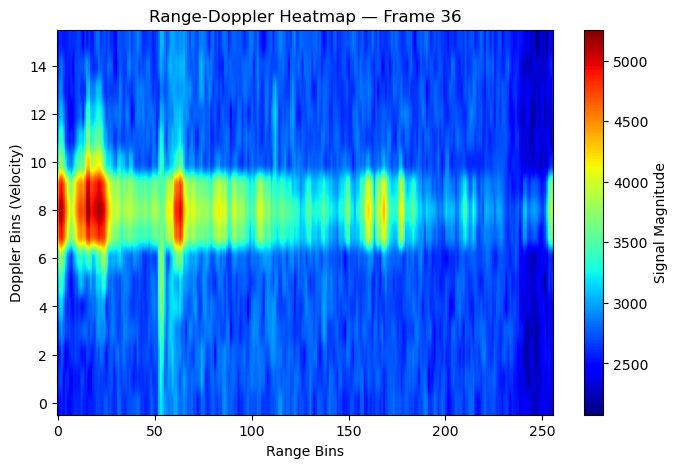

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
heatmap = ax.imshow(doppz_all[0], aspect='auto', cmap='jet', origin='lower')
plt.colorbar(heatmap, ax=ax, label="Signal Magnitude")
ax.set_xlabel("Range Bins")
ax.set_ylabel("Doppler Bins (Velocity)")

def update(frame):
    heatmap.set_array(doppz_all[frame])
    ax.set_title(f"Range-Doppler Heatmap — Frame {frame + 1}")
    return [heatmap]

ani = animation.FuncAnimation(
    fig, update, frames=len(doppz_all),
    interval=500, blit=True
)


ani.save("doppz_heatmap_animation.gif", writer="pillow")

plt.show()


